In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


# EDA - evaluating training data

Time series data is tricky sometimes. The probability distribution may change with time (a non-stationary time series) and that messes everything up: you can't use the past to predict the future when it's non-stationary. Let's check that.

For the most of this notebook we'll use the base train set, so let's load it.

In [2]:
train_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set-base.parquet'))

## Time-series behavior

Let's first look at the total sales by month, to give us an idea of trends.

<AxesSubplot:xlabel='date_block_num'>

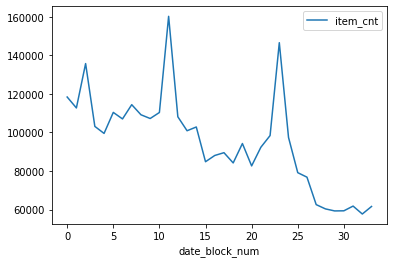

In [3]:
train_set.groupby('date_block_num')['item_cnt'].sum().reset_index().plot.line(x='date_block_num', y='item_cnt')

Uh oh. seems like they are in a downwards trend. There are some crazy peaks there, so let's check if they are related to the specific month.

In [4]:
train_set['month_id'] = train_set['date_block_num'] % 12
train_set['year_id'] = train_set['date_block_num'] // 12

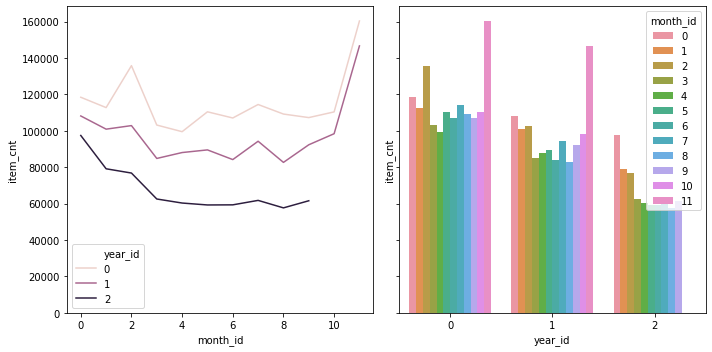

In [5]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
df_tmp = train_set.groupby(['month_id', 'year_id'])['item_cnt'].sum().reset_index()
sns.lineplot(data=df_tmp, x='month_id', y='item_cnt', hue='year_id', ax=axes[0])
sns.barplot(data=df_tmp, x='year_id', y='item_cnt', hue='month_id', ax=axes[1])
plt.tight_layout()

Ok, month 11 really stands out from the rest on every year. It's interesting to see the relationship between monthly sales kind of match each year, specially if you see  the spikes on months 3, 7, and 11. This _might_ mean it'd be ok for us to use all months for training. As per usual, let's save these new information and move on. Notice we also add the date block from test set to save it as well.

In [6]:
date_block_nums = np.arange(0, train_set['date_block_num'].max() + 2)
date_ids = pd.DataFrame({'date_block_num': date_block_nums,
                         'month_id': date_block_nums % 12,
                         'year_id': date_block_nums // 12})
date_ids.to_parquet(os.path.join(PROCESSED_DATA_DIR, 'date-ids.parquet'))

## Item, shops, and categories over time

We analyzed the sales, but let's see how the number of items/categories/shops changed over the months. 

An important note here is that we are assuming the items on the test set to have at least one sale since we're including them in this analysis and the training set only includes items that were sold. It is not true for the general case, but I'd say it's a harmless assumption for now. Either way we will see if we get results that are consistent enough that we can use this.

In [7]:
test_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'test-set-base.parquet'))
frequencies_df = pd.concat([train_set, test_set], axis=0).drop(columns=['ID', 'item_cnt', 'month_id', 'year_id'])

In [8]:
frequencies_df

,date_block_num,item_id,shop_id
0,0,33,2
1,0,317,2
2,0,438,2
3,0,471,2
4,0,481,2
...,...,...,...
214195,34,18454,45
214196,34,16188,45
214197,34,15757,45
214198,34,19648,45


<AxesSubplot:xlabel='date_block_num'>

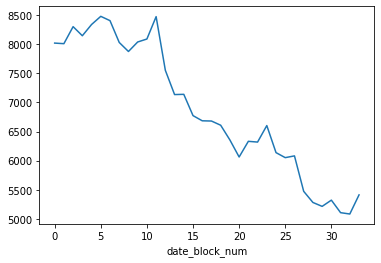

In [9]:
train_set.groupby('date_block_num')['item_id'].nunique().plot.line()

<AxesSubplot:xlabel='date_block_num'>

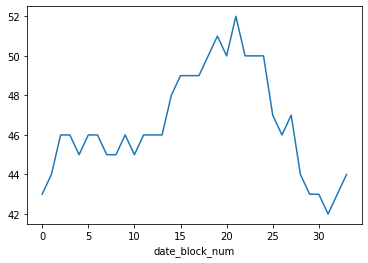

In [10]:
train_set.groupby('date_block_num')['shop_id'].nunique().plot.line()

<AxesSubplot:xlabel='date_block_num'>

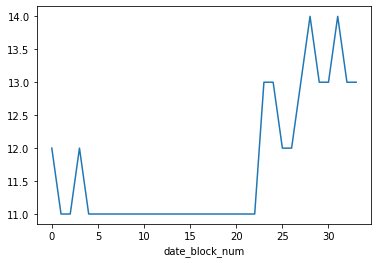

In [11]:
item_categories_metadata = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'item-categories-metadata.parquet'))
train_set.merge(item_categories_metadata, on='item_id').groupby('date_block_num')['category_name'].nunique().plot.line()

This shows the frequencies of our test set kind of follows the rest of the dataset trend now. It might be because of a completely wrong assumption, but we still have to inverstigate it further.

We'll save all of this for feature engineering later. Not much we can do here probably.

In [13]:
train_set.merge(item_categories_metadata, on='item_id')\
         .groupby('date_block_num')\
         .agg({'category_name': 'nunique',
               'shop_id': 'nunique',
               'item_id': 'nunique'})\
         .reset_index()\
         .rename(columns={'category_name': 'nunique_category_names',
                          'shop_id': 'nunique_shop_ids',
                          'item_id': 'nunique_item_ids'})\
        .to_parquet(os.path.join(PROCESSED_DATA_DIR, 'base-ids-monthly-freqs.parquet'))